<a href="https://colab.research.google.com/github/Argel-Tal/Argel-Tal/blob/main/GAN_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up for Generative Adversarial Network training and demonstration

An example of training an unconditional gan on the fashion mnist dataset

Code taken from: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [7]:
# necessary imports for code functions
# !pip install pyyaml h5py  # Required to save models in HDF5 format
from matplotlib import pyplot

from numpy import expand_dims
from numpy import zeros
from numpy import ones

from numpy.random import randn
from numpy.random import randint

from keras.datasets.fashion_mnist import load_data

from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate

from keras.models import Sequential
from keras.models import load_model
from keras.models import Model

# utility import
#!pip install icecream
from icecream import ic
import time


In [8]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


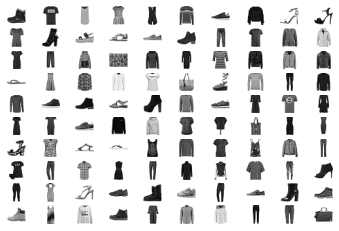

In [9]:
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

# Defining a non-categorical GAN
### Simplest form of GAN, doesn't know what it's drawing, so good for uncategorised data

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [12]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

In [13]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [14]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [15]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [16]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [17]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    ic()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    ic()
    g_model.save('generator.h5')
    
    
    

# Loading a saved version of the GAN
### Files need to be inside the working directory (may need to upload to drive, through the files section)

In [30]:
# loading saved version of the model
# taken from https://www.tensorflow.org/tutorials/keras/save_and_load
# warnining resolution: https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

new_model = tf.keras.models.load_model('generator.h5')

# Training the GAN
### this is pretty time intensive. If you're not already running on GPU, switch over now

In [31]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
ic(train(new_model, discriminator, gan_model, dataset, latent_dim))   # train on loaded version of model, overrides saved file with next itteration
# ic(train(generator, discriminator, gan_model, dataset, latent_dim)) # train from scratch, overrides any loaded model versions

ic| <ipython-input-18-c38c2110ee9b>:5 in train() at 04:58:34.805


>1, 1/468, d1=0.721, d2=0.719 g=0.693
>1, 2/468, d1=0.684, d2=0.724 g=0.691
>1, 3/468, d1=0.675, d2=0.724 g=0.688
>1, 4/468, d1=0.675, d2=0.723 g=0.685
>1, 5/468, d1=0.681, d2=0.719 g=0.683
>1, 6/468, d1=0.686, d2=0.721 g=0.678
>1, 7/468, d1=0.684, d2=0.724 g=0.675
>1, 8/468, d1=0.695, d2=0.705 g=0.669
>1, 9/468, d1=0.689, d2=0.714 g=0.664
>1, 10/468, d1=0.687, d2=0.712 g=0.661
>1, 11/468, d1=0.688, d2=0.709 g=0.655
>1, 12/468, d1=0.687, d2=0.715 g=0.646
>1, 13/468, d1=0.680, d2=0.707 g=0.642
>1, 14/468, d1=0.681, d2=0.707 g=0.634
>1, 15/468, d1=0.678, d2=0.704 g=0.624
>1, 16/468, d1=0.680, d2=0.710 g=0.621
>1, 17/468, d1=0.682, d2=0.707 g=0.608
>1, 18/468, d1=0.682, d2=0.720 g=0.605
>1, 19/468, d1=0.695, d2=0.714 g=0.594
>1, 20/468, d1=0.682, d2=0.717 g=0.586
>1, 21/468, d1=0.693, d2=0.704 g=0.580
>1, 22/468, d1=0.689, d2=0.702 g=0.576
>1, 23/468, d1=0.690, d2=0.708 g=0.570
>1, 24/468, d1=0.691, d2=0.700 g=0.569
>1, 25/468, d1=0.680, d2=0.701 g=0.567
>1, 26/468, d1=0.680, d2=0.695 g=0

ic| <ipython-input-18-c38c2110ee9b>:28 in train() at 04:59:05.875


>1, 466/468, d1=0.581, d2=0.568 g=0.000
>1, 467/468, d1=0.570, d2=0.633 g=0.000
>1, 468/468, d1=0.652, d2=0.634 g=0.000


ic| train(new_model, discriminator, gan_model, dataset, latent_dim): None


# Visualisaing the results of GAN training

In [32]:
# example of loading the generator model and generating images

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [33]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

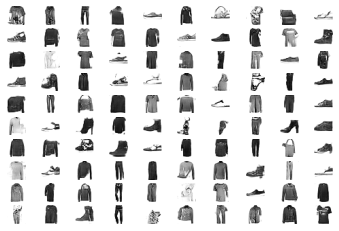

In [57]:
# load model
model = load_model('generator.h5', compile = False)  # use this if training has been done this session
# model = new_model                                   # use this is just loading a model, no training done this session
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points[0]) # if this complains use either latent_points[0] or latent_points, reverse of which ever is causing the complaint
# plot the result
show_plot(X, 10)

# Defining a Conditional GAN
### This model is fed categorical data, defining the type of object it is drawing. This requires detailed datasets, but is much more accurate at doing multiple things, bc it can differentiate between them.

Switching to a conditional GAN
An example of training an conditional gan on the fashion mnist dataset

In [40]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [41]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [42]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [43]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

In [44]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [45]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [46]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [103]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    ic()
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    ic()
    g_model.save('cgan_generator.h5')

# Loading a saved version of the C_GAN
### Files need to be inside the working directory (may need to upload to drive, through the files section)

In [134]:
# do this after training, unless loading previously trained model
new_cgan_model = tf.keras.models.load_model('cgan_generator.h5', compile = False)
#new_cgan_model.summary() # nice printout of the GAN's values

# Training the C_GAN
### Again, this is pretty time intensive. If you're not already running on GPU, switch over now

In [138]:
new_cgan_model.build(2) # use this if training from saved version
# g_model.build(2) # use this if NOT training from saved version

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

# train model
sTime = time.time()
ic(train(g_model, d_model, gan_model, dataset, latent_dim))        # train from scratch, overrides any loaded model versions
#ic(train(new_cgan_model, d_model, gan_model, dataset, latent_dim))  # train from saved version of model, overrides any loaded model versions
finTime = time.time()


ic| <ipython-input-103-007c47244cbd>:6 in train() at 07:31:00.124


Streaming output truncated to the last 5000 lines.
>20, 148/468, d1=0.680, d2=0.637 g=0.793
>20, 149/468, d1=0.663, d2=0.628 g=0.815
>20, 150/468, d1=0.684, d2=0.658 g=0.773
>20, 151/468, d1=0.684, d2=0.683 g=0.776
>20, 152/468, d1=0.678, d2=0.652 g=0.777
>20, 153/468, d1=0.714, d2=0.666 g=0.794
>20, 154/468, d1=0.716, d2=0.695 g=0.759
>20, 155/468, d1=0.661, d2=0.651 g=0.722
>20, 156/468, d1=0.677, d2=0.706 g=0.742
>20, 157/468, d1=0.667, d2=0.676 g=0.781
>20, 158/468, d1=0.654, d2=0.652 g=0.790
>20, 159/468, d1=0.655, d2=0.656 g=0.793
>20, 160/468, d1=0.680, d2=0.662 g=0.767
>20, 161/468, d1=0.663, d2=0.717 g=0.783
>20, 162/468, d1=0.710, d2=0.681 g=0.772
>20, 163/468, d1=0.682, d2=0.671 g=0.750
>20, 164/468, d1=0.663, d2=0.691 g=0.774
>20, 165/468, d1=0.694, d2=0.659 g=0.797
>20, 166/468, d1=0.681, d2=0.685 g=0.771
>20, 167/468, d1=0.659, d2=0.658 g=0.801
>20, 168/468, d1=0.706, d2=0.677 g=0.787
>20, 169/468, d1=0.692, d2=0.668 g=0.769
>20, 170/468, d1=0.655, d2=0.644 g=0.788
>20, 1

ic| <ipython-input-103-007c47244cbd>:28 in train() at 07:49:18.843
ic| train(g_model, d_model, gan_model, dataset, latent_dim): None


>30, 468/468, d1=0.650, d2=0.625 g=0.807


In [139]:
# training total time
(finTime - sTime)/60 # minutes of train time

18.31478006442388

In [140]:
gan_model.summary() # nice printout of the GAN's values

Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_79 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 6272)         633472      input_80[0][0]                   
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 50)        500         input_79[0][0]                   
___________________________________________________________________________________________

# Visualisaing the results of C_GAN training

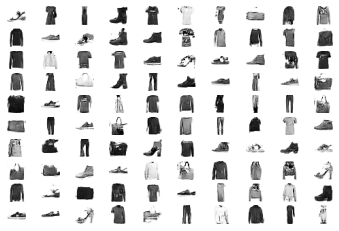

In [141]:
# load model

model = load_model('cgan_generator.h5', compile = False) # use this if you've evolved a model
# model = new_cgan_model                  # use this if you've only loaded a model, no training this session
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points) # may need to be latent_points[0]
# plot the result
show_plot(X, 10)

# Final bits of admin

In [133]:
# lists all files in current directory, may want to save these files externally
!ls

cgan_generator.h5  generator2.h5  generator.h5	sample_data
